# Overview

Here we are simply trying to minimize the root mean square error for predicting the 16th, 50th, 84th percentile [O/H] and 50th percentile of the stellar mass.

# Imports and other necessary functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import torch 

from IPython.display import display


In [2]:
torch.cuda.set_device(0)

In [3]:
PATH = os.path.abspath('..')

In [4]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Initialize network

Let's do it

In [5]:
train_label_csv = f'{PATH}/catalogs/train-mass-metal.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)

# test-val split
val_idxs = get_cv_idxs(n)

In [6]:
sz = 128
bs = 128
arch = resnet34

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-mass-metal', num_workers=8)

In [7]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

In [8]:
df.describe()

,oh_p16,oh_p50,oh_p84,lgm_tot_p50
count,95986.000000,95986.000000,95986.000000,95986.000000
mean,8.858187,8.906781,8.951449,10.012809
std,0.231597,0.199232,0.179088,0.560161
min,7.771679,7.851740,7.907599,6.140463
25%,8.746622,8.809235,8.846242,9.646171
50%,8.925781,8.955896,8.992349,10.058685
75%,9.015585,9.054318,9.085357,10.422712
max,9.463200,9.469999,9.476800,12.483970


In [8]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

 82%|████████▏ | 979/1200 [01:17<00:17, 12.56it/s, loss=1.67] 

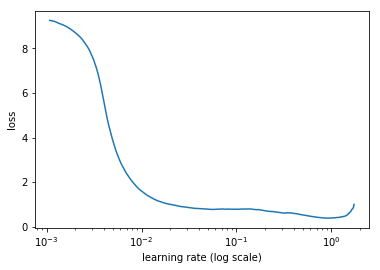

In [44]:
learn.lr_find(start_lr=1e-3)
learn.sched.plot()

# Begin training

Here we will try defining specific learning rate phases, as described by [Sylvain Gugger](https://github.com/fastai/fastai/blob/master/courses/dl2/training_phase.ipynb)

In [45]:
lr = 0.1
learn.fit(lr, n_cycle=1, cycle_len=1)

 82%|████████▏ | 979/1200 [01:35<00:21, 10.22it/s, loss=1.67]

epoch      trn_loss   val_loss                                 
    0      0.274872   0.240984  


[array([0.24098])]

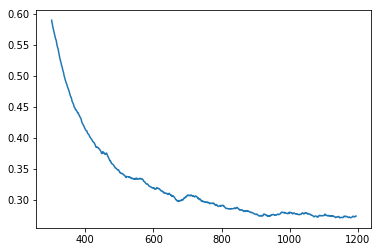

In [47]:
learn.sched.plot_loss(n_skip=300)

In [49]:
learn.fit(lr, n_cycle=1, cycle_len=1)

epoch      trn_loss   val_loss                                 
    0      0.245833   0.233329  


[array([0.23333])]

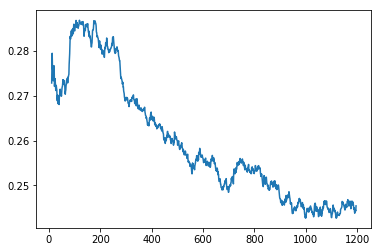

In [50]:
learn.sched.plot_loss()

In [52]:
learn.save('resnet34_mass-metal_sz128-bs128_init')

## Unfreeze early layers

### Begin differential learning with annealed learning rate

In [53]:
learn.unfreeze()
lrs = 1e-2 * np.array([1e-2, 1e-1, 1])

learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                 
    0      0.197856   0.189447  
    1      0.176862   0.170419                                 
    2      0.175883   0.167905                                 
    3      0.169602   0.162096                                 
    4      0.167781   0.157846                                 
    5      0.169181   0.158147                                 
    6      0.166831   0.157194                                 


[array([0.15719])]

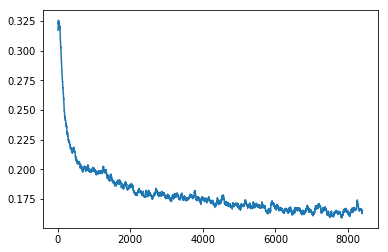

In [54]:
learn.sched.plot_loss()

~20 minutes

In [9]:
#learn.save('resnet34_mass-metal_sz128-bs128_diff-1')
learn.load('resnet34_mass-metal_sz128-bs128_diff-1')

In [12]:
p_val, y_val = learn.TTA()
pred_val = np.mean(p_val, axis=0)

rms_errors = np.sqrt(np.mean((pred_val - y_val)**2, axis=0))

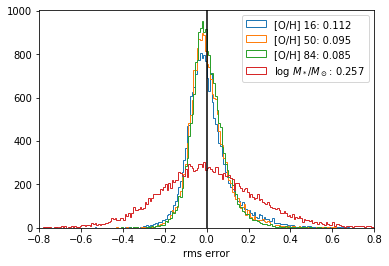

In [13]:
for i in range(4):
    plt.hist(pred_val[:, i]-y_val[:, i], bins=200, histtype='step', range=[-0.8, 0.8]);
plt.legend([f'{percentile:>5s}: {error:.3f}' for percentile, error in zip(['[O/H] 16', '[O/H] 50', '[O/H] 84', r'log $M_*/M_\odot$'], rms_errors)]);
plt.xlim(-0.8, 0.8)
plt.axvline(0, c='k')
plt.xlabel('rms error');

## Save out test predictions

In [33]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)

df_test = pd.read_csv(f'{PATH}/catalogs/test-mass-metal.csv', index_col=0)
y_test = df_test.loc[test_names].lgm_tot_p50.values

In [16]:
preds, _ = learn.TTA(is_test=True)
p_test = np.mean(preds, axis=0)

In [39]:
# also interesting to keep O/H values
oh_p50 = df_test.loc[test_names].oh_p50.values

predicted = pd.DataFrame({'lgm_tot_p50': y_test, 'cnn_lgm': p_test[:, 3], 'oh_p50': oh_p50})
predicted.index = df_test.loc[test_names].index

predicted.to_csv(f'{PATH}/catalogs/predictions-lgm_p50.csv')

# Results and evaluation

## Lowest metallicity (50th percentile)

Prediction: 8.253, True: 8.022, error: 0.231


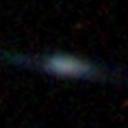

Prediction: 8.258, True: 8.116, error: 0.142


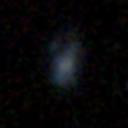

Prediction: 8.273, True: 8.276, error: 0.002


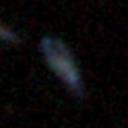

Prediction: 8.296, True: 8.294, error: 0.002


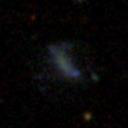

Prediction: 8.298, True: 8.140, error: 0.158


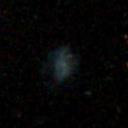

In [13]:
for idx in np.argsort(pred_val[:, 1])[:5]:
    p = pred_val[idx, 1]
    y = y_val[idx, 1]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.val_ds.fnames[idx]))

## Highest metallicity (50th percentile) 

Prediction: 9.177, True: 9.128, error: 0.049


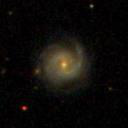

Prediction: 9.177, True: 9.145, error: 0.032


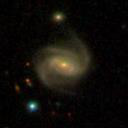

Prediction: 9.169, True: 9.184, error: 0.014


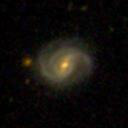

Prediction: 9.166, True: 9.139, error: 0.026


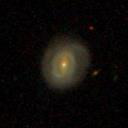

Prediction: 9.165, True: 9.171, error: 0.007


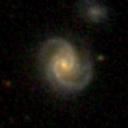

In [15]:
for idx in list(reversed(np.argsort(pred_val[:, 1])))[:5]:
    p = pred_val[idx, 1]
    y = y_val[idx, 1]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.val_ds.fnames[idx]))

## Most uncertain metallicity (50th percentile)

Prediction: 8.893, True: 7.955, error: 0.938


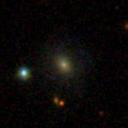

Prediction: 9.046, True: 8.323, error: 0.723


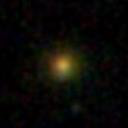

Prediction: 9.067, True: 8.363, error: 0.704


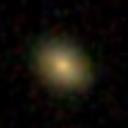

Prediction: 9.095, True: 8.462, error: 0.634


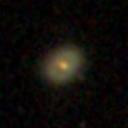

Prediction: 9.056, True: 8.431, error: 0.625


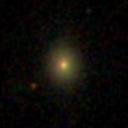

Prediction: 8.996, True: 8.386, error: 0.610


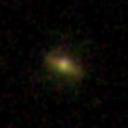

Prediction: 9.044, True: 8.446, error: 0.598


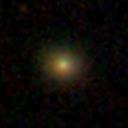

Prediction: 8.747, True: 8.150, error: 0.597


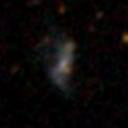

Prediction: 9.030, True: 8.436, error: 0.594


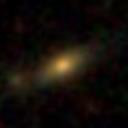

Prediction: 9.076, True: 8.482, error: 0.594


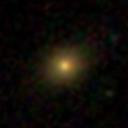

In [16]:
for idx in list(reversed(np.argsort((pred_val[:, 1] - y_val[:, 1])**2)))[:10]:
    p = pred_val[idx, 1]
    y = y_val[idx, 1]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.val_ds.fnames[idx]))

## Lowest stellar mass

Prediction: 8.529, True: 8.340, error: 0.189


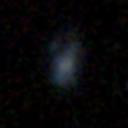

Prediction: 8.562, True: 8.347, error: 0.215


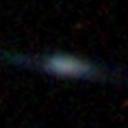

Prediction: 8.618, True: 8.424, error: 0.194


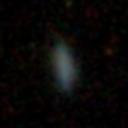

Prediction: 8.621, True: 8.845, error: 0.224


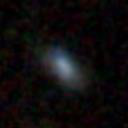

Prediction: 8.626, True: 8.595, error: 0.031


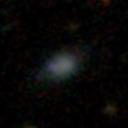

In [17]:
for idx in np.argsort(pred_val[:, 3])[:5]:
    p = pred_val[idx, 3]
    y = y_val[idx, 3]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.val_ds.fnames[idx]))

## Highest stellar mass

Prediction: 11.136, True: 11.404, error: 0.268


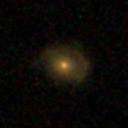

Prediction: 11.113, True: 11.554, error: 0.441


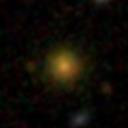

Prediction: 11.083, True: 11.404, error: 0.321


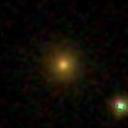

Prediction: 11.078, True: 11.364, error: 0.286


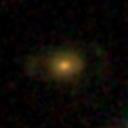

Prediction: 11.076, True: 11.442, error: 0.366


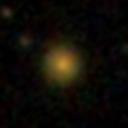

In [18]:
for idx in list(reversed(np.argsort(pred_val[:, 3])))[:5]:
    p = pred_val[idx, 3]
    y = y_val[idx, 3]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.val_ds.fnames[idx]))

## Most uncertain stellar mass

Prediction: 9.265, True: 11.462, error: -2.197
Pred metallicity: 8.686, True metallicity: 9.173, error: -0.486


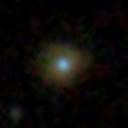

Prediction: 10.127, True: 7.950, error: 2.177
Pred metallicity: 8.986, True metallicity: 9.058, error: -0.072


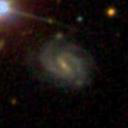

Prediction: 10.240, True: 8.234, error: 2.006
Pred metallicity: 8.982, True metallicity: 9.049, error: -0.067


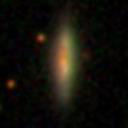

Prediction: 9.447, True: 7.472, error: 1.974
Pred metallicity: 8.703, True metallicity: 8.660, error: 0.042


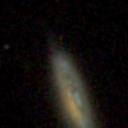

Prediction: 10.185, True: 8.356, error: 1.829
Pred metallicity: 9.047, True metallicity: 9.050, error: -0.003


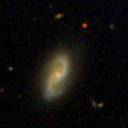

Prediction: 10.232, True: 12.060, error: -1.827
Pred metallicity: 9.037, True metallicity: 9.066, error: -0.030


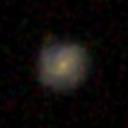

Prediction: 9.616, True: 11.306, error: -1.690
Pred metallicity: 8.768, True metallicity: 8.569, error: 0.199


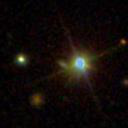

Prediction: 8.890, True: 7.201, error: 1.689
Pred metallicity: 8.412, True metallicity: 8.526, error: -0.114


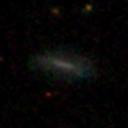

Prediction: 10.221, True: 8.542, error: 1.679
Pred metallicity: 8.949, True metallicity: 8.878, error: 0.071


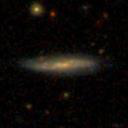

Prediction: 9.433, True: 11.031, error: -1.598
Pred metallicity: 8.766, True metallicity: 9.111, error: -0.346


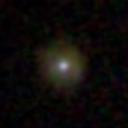

In [19]:
for idx in list(reversed(np.argsort((pred_val[:, 3] - y_val[:, 3])**2)))[10:20]:
    p = pred_val[idx, 3]
    y = y_val[idx, 3]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, p-y))
    print('Pred metallicity: {:.3f}, True metallicity: {:.3f}, error: {:.3f}'.format(pred_val[idx, 1], y_val[idx, 1], pred_val[idx, 1] -  y_val[idx, 1]))
    display(PIL.Image.open(PATH + '/' + learn.data.val_ds.fnames[idx]))

## Correlation of errors:


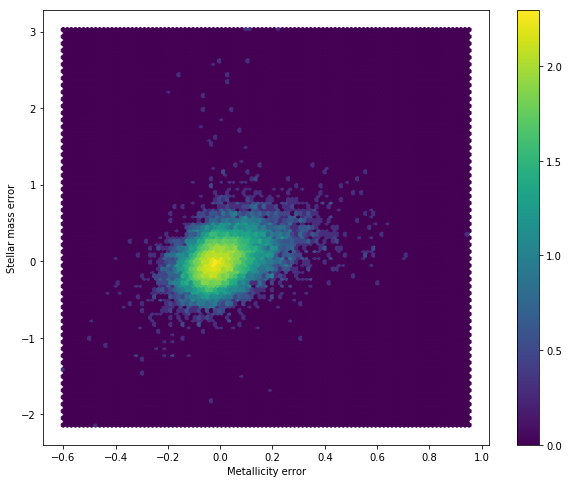

In [92]:
p_met = pred_val[:, 1]
y_met = y_val[:, 1]
p_mass = pred_val[:, 3]
y_mass = y_val[:, 3]

plt.figure(figsize=(10, 8))
plt.hexbin(p_met - y_met, p_mass - y_mass, bins='log')
plt.xlabel('Metallicity error')
plt.ylabel('Stellar mass error')
plt.colorbar();

## Mass and metallcitiy pdfs

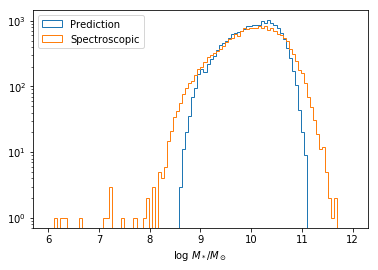

In [81]:
plt.hist(pred_val[:, 3], range=[6, 12], bins=100, histtype='step', label='Prediction')
plt.hist(y_val[:, 3], range=[6, 12], bins=100, histtype='step', label='Spectroscopic')
plt.xlabel(r'log $M_*/M_\odot$')
plt.yscale('log')
plt.legend(loc='upper left');

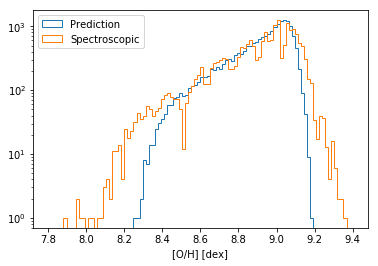

In [94]:
plt.hist(pred_val[:, 1], range=[7.8, 9.4], bins=100, histtype='step', label='Prediction')
plt.hist(y_val[:, 1], range=[7.8, 9.4], bins=100, histtype='step', label='Spectroscopic')
plt.xlabel(r'[O/H] [dex]')
plt.yscale('log')
plt.legend(loc='upper left');

## Remarks

- It fails to predict low-mass objects
- The predicted distributions of properties are narrower than their "true" distributions
- There doesn't seem to be much morphological distinction between low-metallicty and high-metallicity objects, but our network is still able to predict them quite well.
- RMSE / STD for metallicity is ~ 0.10 / 0.20, and for mass is ~0.26 / 0.56. So the error scaled by precision is about the same for both quantities.

# Final training and results

In [7]:
train_label_csv = f'{PATH}/catalogs/train-mass-metal.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)

In [20]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train-mass-metal', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-mass-metal', num_workers=16)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

In [21]:
# train-val permutation
all_idxs = np.random.permutation(range(n))

# params
sz = 128
bs = 128
arch = resnet34

In [22]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

Our standard training

epoch      trn_loss   val_loss                                 
    0      0.260755   0.23891   
    1      0.24789    0.233056                                 



epoch      trn_loss   val_loss                                 
    0      0.164672   0.158926  



epoch      trn_loss   val_loss                                 
    0      0.151843   0.141009  
    1      0.157706   0.145081                                 
    2      0.145373   0.137949                                 
    3      0.158363   0.146914                                 
    4      0.151102   0.142367                                 
    5      0.145307   0.135571                                 
    6      0.1373     0.133994                                 



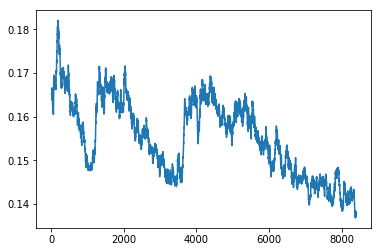

In [23]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [24]:
#learn.save('resnet34_mass-metal_final')
learn.load('resnet34_mass-metal_final')

In [25]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)

df_test = pd.read_csv(f'{PATH}/catalogs/test-mass-metal.csv', index_col=0)
y_test = df_test.loc[test_names].lgm_tot_p50.values

In [26]:
preds, _ = learn.TTA(is_test=True)
p_test = np.mean(preds, axis=0)

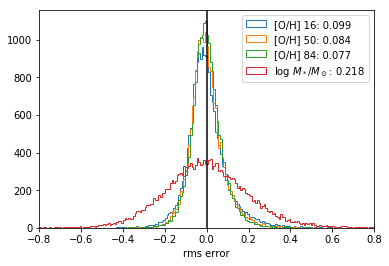

In [31]:
rms_errors = np.sqrt(np.mean((p_test - df_test.loc[test_names].values)**2, axis=0))
for i in range(4):
    plt.hist(p_test[:, i]-df_test.loc[test_names].values[:, i], bins=200, histtype='step', range=[-0.8, 0.8]);
plt.legend([f'{percentile:>5s}: {error:.3f}' for percentile, error in zip(['[O/H] 16', '[O/H] 50', '[O/H] 84', r'log $M_*/M_\odot$'], rms_errors)]);
plt.xlim(-0.8, 0.8)
plt.axvline(0, c='k')
plt.xlabel('rms error');

In [27]:
# also interesting to keep O/H values
oh_p50 = df_test.loc[test_names].oh_p50.values

predicted = pd.DataFrame({'lgm_tot_p50': y_test, 'cnn_lgm': p_test[:, 3], 'oh_p50': oh_p50, 'cnn_oh': p_test[:, 1]})
predicted.index = df_test.loc[test_names].index

predicted.to_csv(f'{PATH}/catalogs/predictions-mass-metal.csv')

# Predicting *only* mass

Saving out catalogs with mass only

In [35]:
df = pd.read_csv(f'{PATH}/catalogs/train-mass-metal.csv', index_col=0)
df.drop(labels=['oh_p16', 'oh_p50', 'oh_p84'], axis='columns', inplace=True)
df.to_csv(f'{PATH}/catalogs/train-mass-only.csv')

df = pd.read_csv(f'{PATH}/catalogs/test-mass-metal.csv', index_col=0)
df.drop(labels=['oh_p16', 'oh_p50', 'oh_p84'], axis='columns', inplace=True)
df.to_csv(f'{PATH}/catalogs/test-mass-only.csv')


In [36]:
train_label_csv = f'{PATH}/catalogs/train-mass-only.csv'
df = pd.read_csv(train_label_csv, index_col=0)

n = len(df)
val_idxs = get_cv_idxs(n)

In [41]:
def get_data(arch, sz, bs, val_idxs=val_idxs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train-mass-metal', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-mass-metal', num_workers=16)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

In [42]:
# train-val permutation
all_idxs = np.random.permutation(range(n))

# params
sz = 128
bs = 128
arch = resnet34

In [43]:
data = get_data(arch, sz, bs, val_idxs=val_idxs)

learn = ConvLearner.pretrained(arch, data)
metrics = [rmse]
learn.crit = rmse

epoch      trn_loss   val_loss                                 
    0      0.433697   0.403015  
    1      0.43952    0.399656                                 



epoch      trn_loss   val_loss                                 
    0      0.308722   0.296928  



epoch      trn_loss   val_loss                                 
    0      0.25564    0.238732  
    1      0.267568   0.26231                                  
    2      0.249268   0.231886                                 
    3      0.286855   0.272923                                 
    4      0.268357   0.24854                                  
    5      0.253172   0.237333                                 
    6      0.237163   0.225611                                 



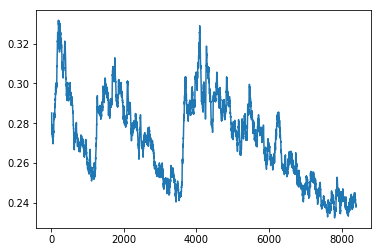

In [45]:
lr = 1e-1
learn.fit(lr, 2)

lrs = [1e-3, 1e-2, 1e-1]
learn.unfreeze()
learn.fit(lr, 1)
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

In [46]:
#learn.save('resnet34_mass-only')
learn.load('resnet34_mass-only')

In [47]:
test_names = np.array([os.path.split(fname)[1][:-4] for fname in learn.data.test_ds.fnames], dtype=np.int64)

df_test = pd.read_csv(f'{PATH}/catalogs/test-mass-only.csv', index_col=0)
y_test = df_test.loc[test_names].lgm_tot_p50.values

In [48]:
preds, _ = learn.TTA(is_test=True)
p_test = np.mean(preds, axis=0)

In [49]:
predicted = pd.DataFrame({'lgm_tot_p50': y_test, 'cnn_lgm': p_test[:, 0]})
predicted.index = df_test.loc[test_names].index

predicted.to_csv(f'{PATH}/catalogs/predictions-mass.csv')